In [2]:
#loading dataset
import pandas as pd

df=pd.read_csv("salary.csv")
df.head(3)

,skill_count,salary_lpa
0,2,2.8
1,2,3.0
2,3,3.1


In [3]:
#information of dataset
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   skill_count  50 non-null     int64  
 1   salary_lpa   50 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 928.0 bytes


(50, 2)

In [4]:
#adding new constant cloumn that is intercept value as 1 that is (beta0) value that can be done with statsmodel.api and x (independent variable) is skill_count in this dataset

import statsmodels.api as sm

X=sm.add_constant(df['skill_count'])
X.head(3)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,skill_count
0,1.0,2
1,1.0,2
2,1.0,3


In [5]:
#creating an output variable Y (dependent variable)

Y=df['salary_lpa']
Y.head(3)

0    2.8
1    3.0
2    3.1
Name: salary_lpa, dtype: float64

In [6]:
#splittting dataset into training and validation by 80-20 percentage and setting random state as 100 (random avoid different output values every time we run the code)

from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X,Y,train_size=0.8,random_state=100)

In [7]:
#fitting the model that is linear regression
salary_lm = sm.OLS(train_Y, train_X).fit()

In [8]:
#printing the estimated parameters beta0 and beta1 then the salary_lpa=beta0+beta1(skill_count)
print(salary_lm.params)
#then the salary_lpa = 0.957261+0.723968(skill_count)

const          0.957261
skill_count    0.723968
dtype: float64


In [9]:
#model diagnostics-R squared value
print(salary_lm.summary2())
#this shows that from rsquared value 0.989 that is skill_count varies 98% ,that is this effects the value of salary_lpa by 98%

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.988   
Dependent Variable: salary_lpa       AIC:                19.0499 
Date:               2026-02-12 09:09 BIC:                22.4276 
No. Observations:   40               Log-Likelihood:     -7.5249 
Df Model:           1                F-statistic:        3325.   
Df Residuals:       38               Prob (F-statistic): 1.32e-38
R-squared:          0.989            Scale:              0.089785
------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
const            0.9573    0.1139   8.4038  0.0000  0.7267  1.1879
skill_count      0.7240    0.0126  57.6587  0.0000  0.6985  0.7494
-----------------------------------------------------------------
Omnibus:              1.462        Durbin-Watson:           1.487
Prob(Omnibus):        

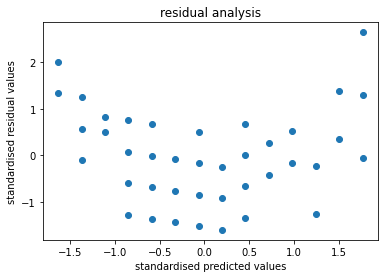

In [10]:
#model diagnostics -  Residual Analysis - variance of the residual has to be constant across different values of the predicted value (Y') - a property known as homoscedasticity. A non-constant variance of the residuals is known as heteroscedasticity - not desired. If there is heteroscedasticity, a residual plot between standardised residual values and standardised predicted values, will be funnel shaped. To standardize, subtract from mean and divide by standard deviation

import matplotlib.pyplot as plt

def standardised_values(vals):
    return (vals-vals.mean())/vals.std()
x_axis=standardised_values(salary_lm.fittedvalues)
y_axis=standardised_values(salary_lm.resid)

#scatter plot 
plt.scatter(x_axis,y_axis)
plt.xlabel("standardised predicted values")
plt.ylabel("standardised residual values")
plt.title("residual analysis")
plt.show()

In [11]:
# Model Diagnostics - Oulier Detection. Outliers are observations whose values show a large deviation from the mean value. Their presence can have a significant influence on the values of the regression coefficients. Hence we use Z-Score to identify their existence in the data. Any obervation with an Z-Score of more than 3.0 is an outlier.
from scipy.stats import zscore

df['z_score_salary'] = zscore(df['salary_lpa'])
#df.head()
df[(df.z_score_salary > 3.0) | (df.z_score_salary < -3.0)]

#no output since there are no outliers

,skill_count,salary_lpa,z_score_salary


In [12]:
#Making predictions on validation set and measuring accuracy - R-Squared and RMSE

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
pred_Y = salary_lm.predict(test_X)
print('R2 Score =',np.abs(r2_score(test_Y,pred_Y)))
print('RMSE = ', np.sqrt(mean_squared_error(test_Y,pred_Y)))

R2 Score = 0.9907049635169516
RMSE =  0.2785737426487337


In [13]:
#sm.OLS uses PandasData, which is just a container for the numbers. smf.ols uses DesignInfo, which contains the "instructions" for the model.
#design_info: This is a roadmap created by the Formula API. It tells the ANOVA function exactly which columns are predictors and which is the intercept.

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Usindg smf.ols instead of sm.OLS
# Format: 'Dependent_Variable ~ Independent_Variable'
# Note: Do NOT use add_constant here; the formula does it .

salary_lm = smf.ols('salary_lpa ~ skill_count', data=df).fit()

anova_results = anova_lm(salary_lm)
print(anova_results)

               df      sum_sq     mean_sq            F        PR(>F)
skill_count   1.0  396.010123  396.010123  4547.835591  3.268045e-49
Residual     48.0    4.179677    0.087077          NaN           NaN


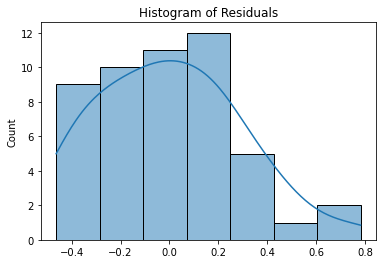

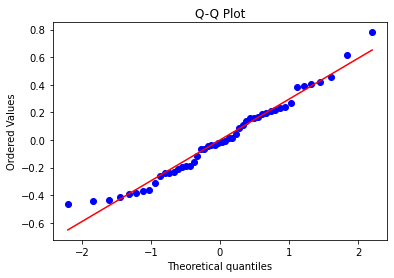

In [16]:
#normality tests -- HISTOGRAM (bell shape means staisfied normality) and QQ-PLOT(cloe to straight line then residuals are normally distributed)
import scipy.stats as stats
import seaborn as sns
residuals = salary_lm.resid

# Histogram
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Q-Q Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

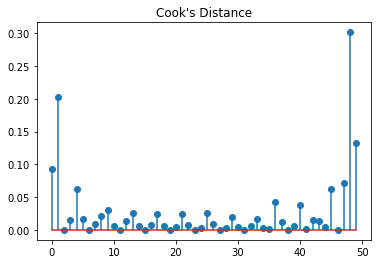

In [18]:
#cooks distance (how much a single observation can influence my model if cooks d > 4/n then the point is influencial here n = size of dataset )

influence = salary_lm.get_influence()
cooks = influence.cooks_distance[0]

plt.stem(cooks)
plt.title("Cook's Distance")
plt.show()